In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [3]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [4]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [5]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [6]:
%%time
channel10 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km/")
channel10_302 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.302K.100km/")
channel10wk = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.walker.100km/")
channel10wk_aqua = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.10mps.walker.100km/")
#channel10wk_aqua_0mps = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.0mps.walker.100km/")
channel10wk_aqua_1mps = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.1mps.walker.100km/")

CPU times: user 2min 56s, sys: 2min 56s, total: 5min 52s
Wall time: 2min 54s


In [7]:
hgt = channel10wk.HGT.isel(south_north=0,Time=-1).persist()
dist=(50-hgt.west_east)*100
def plotsection():
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot(dist,hgt,color='k')
    return ax,ax.twinx()

In [8]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

num_cores = 16
wrf.omp_set_num_threads(32)
def compute_cape(simulation_path,nfiles=None):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    if nfiles:
        files=files[:nfiles]
    capecin_list = Parallel(n_jobs=num_cores)(delayed(compute_individual_cape)(file) for file in files)
    return xr.combine_nested(capecin_list,concat_dim='Time')

In [9]:
%%time 

channel10capecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km/")
channel10CAPEmean = channel10capecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1200)).mean('Time')

channel10_302capecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.302K.100km/")
channel10_302CAPEmean = channel10_302capecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1200)).mean('Time')

channel10wkcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.walker.100km/")
channel10wkCAPEmean = channel10wkcapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1000)).mean('Time')

channel10wk_aquacapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.10mps.walker.100km/")
channel10wk_aquaCAPEmean = channel10wk_aquacapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1000)).mean('Time')

channel10wk_aqua_0mpscapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.0mps.walker.100km/")
channel10wk_aqua_0mpsCAPEmean = channel10wk_aqua_0mpscapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1000)).mean('Time')

CPU times: user 898 ms, sys: 786 ms, total: 1.68 s
Wall time: 30.3 s


In [10]:
channel10wk_aqua_1mpscapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.1mps.walker.100km/")
channel10wk_aqua_1mpsCAPEmean = channel10wk_aqua_1mpscapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(200,1000)).mean('Time')

# Coarse runs analysis

## Lon-lev cross sections

In [40]:
def plot_w(sim,ax,plot_mtn=0,plot_clouds=1):
    w = sim.W.isel(Time=slice(200,1000)).mean(["Time","south_north"])
    w_plot = w.assign_coords({'distance_from_mtn':(50-w.west_east)*100,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    add_text(ax)
    if plot_mtn :
        ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
    if plot_clouds:
        qc = sim.QCLOUD.isel(Time=slice(200,1000)).mean(["Time","south_north"])
        qc_plot = qc.assign_coords({'distance_from_mtn':(50-qc.west_east)*100,'eta_level':sim.ZNU.isel(Time=-1)}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()
        qc_plot.plot.contour(ax=ax, x='distance_from_mtn',yincrease=False,**{'levels':[1e-6,1e-5],'colors':['gray','k']})
        
def plot_w_hovmoeller(sim,ax):
    w = sim.W.isel(Time=slice(200,1000),bottom_top_stag=14).mean("south_north")
    w.plot(ax=ax, x='Time',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    
def plot_pr_hovmoeller(sim,ax):
    pr = 4*(sim.RAINC+sim.RAINNC).isel(Time=slice(200,1000)).diff('Time').mean("south_north")
    pr.plot(ax=ax, x='Time',yincrease=False,levels=np.linspace(0,50),cbar_kwargs={'ticks':np.arange(0,51,10.)})

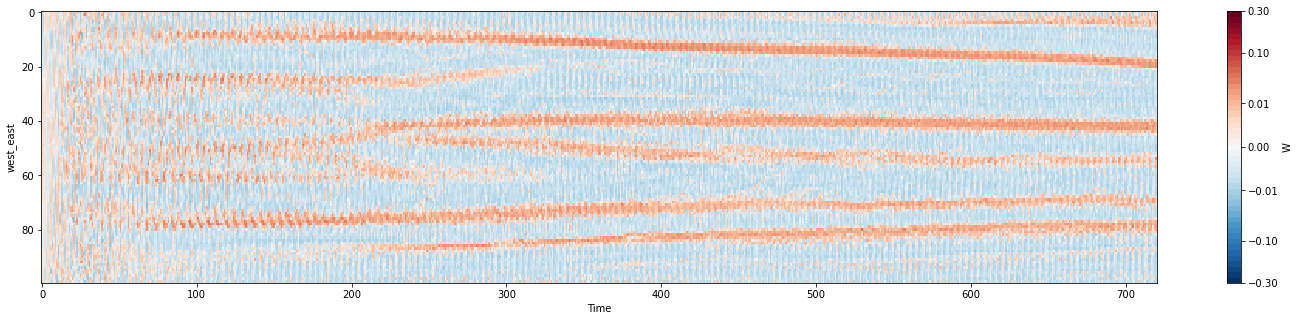

In [64]:
_,ax=plt.subplots(1,1,figsize=(25,5))

w = channel10wk_aqua_0mps_new.W.isel(bottom_top_stag=15).mean(["south_north"])
w.plot(ax=ax, x='Time',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

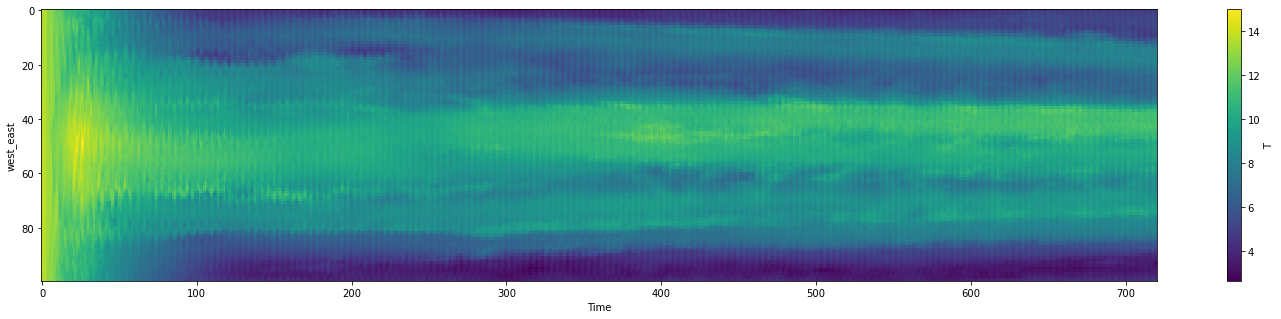

In [66]:
_,ax=plt.subplots(1,1,figsize=(25,5))

w = channel10wk_aqua_0mps_new.T.isel(bottom_top=10).mean(["south_north"])
w.plot(ax=ax, x='Time',yincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

Text(0.5, 1.0, 'mock-Walker with mtn MINUS uniform SST with mtn')

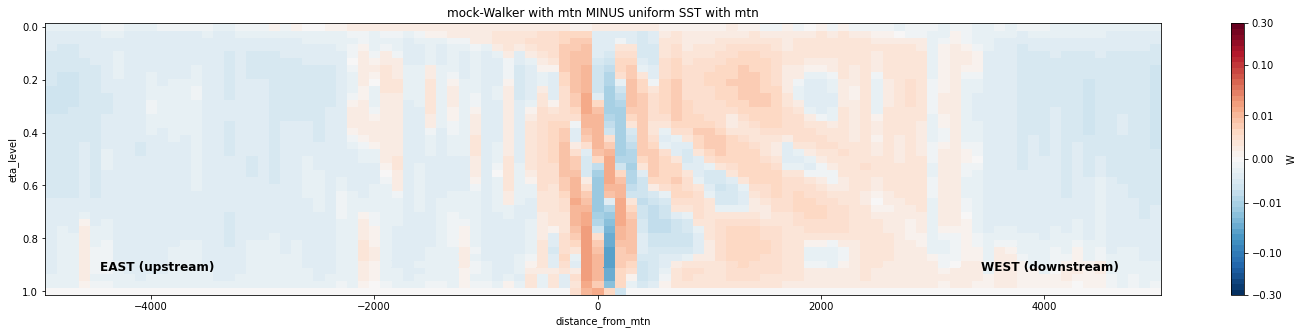

In [81]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w = channel10wk.W.isel(Time=slice(200,1000)).mean(["Time","south_north"])-channel10.W.isel(Time=slice(200,1200)).mean(["Time","south_north"])
w_plot = w.assign_coords({'distance_from_mtn':(50-w.west_east)*100,'eta_level':channel10wk.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
add_text(ax)

ax.set_title("mock-Walker with mtn MINUS uniform 300K SST with mtn")


Text(0.5, 1.0, 'mock-Walker aquaplanet 1m/s - W (nonlinear scale)')

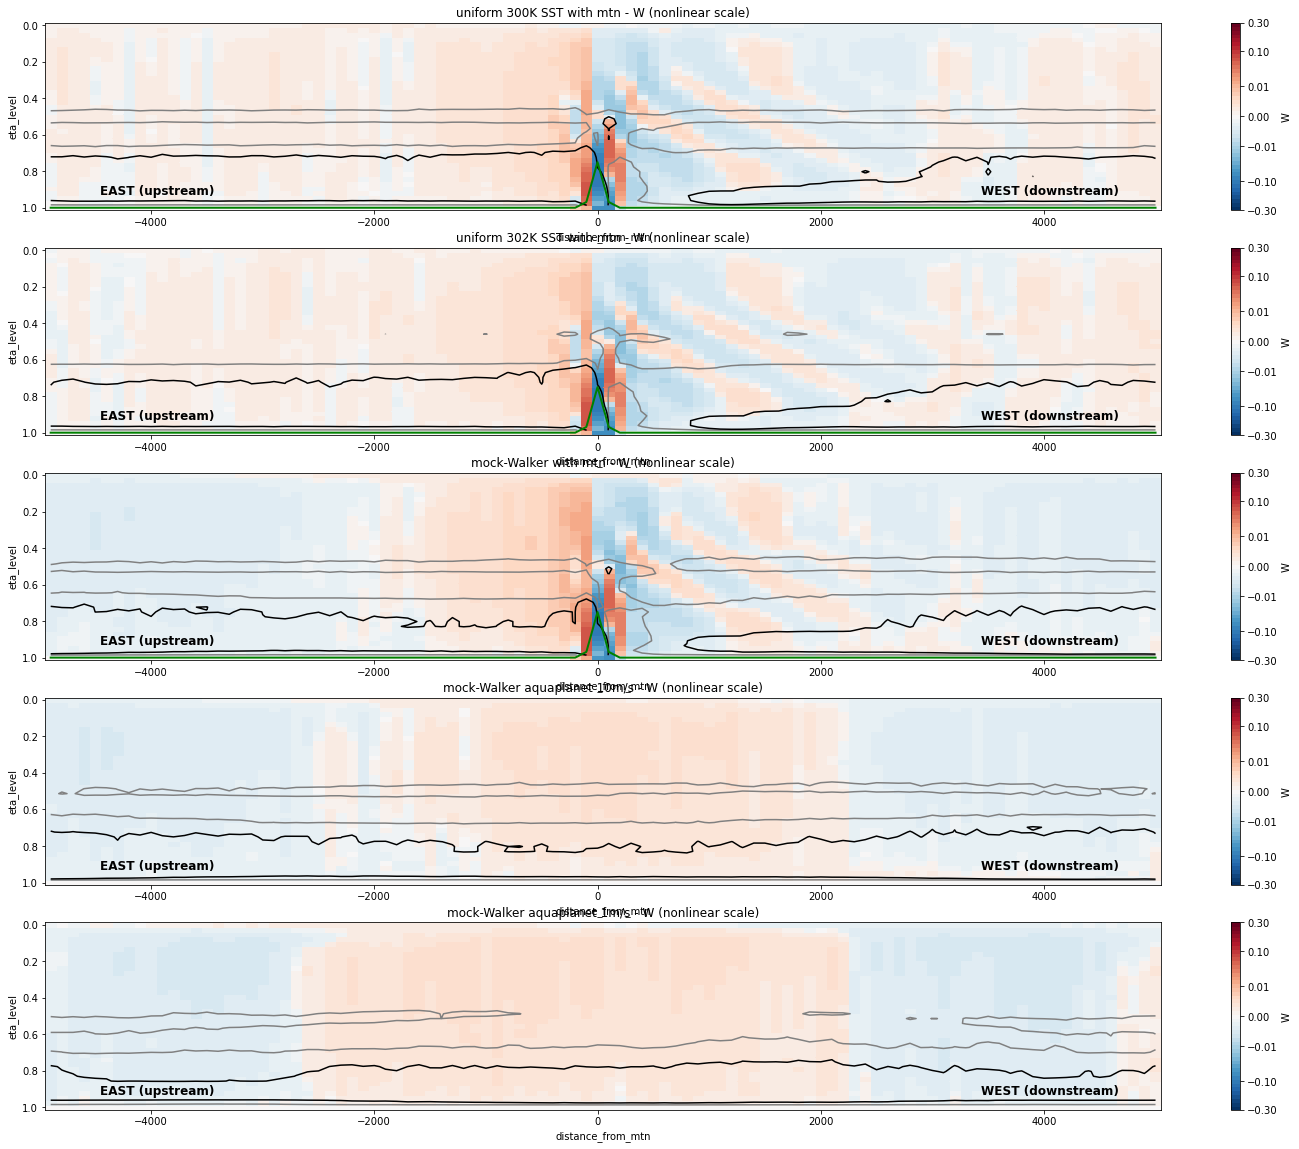

In [22]:
_,ax=plt.subplots(5,1,figsize=(25,20))
plot_w(channel10            ,ax[0],1)
plot_w(channel10_302        ,ax[1],1)
plot_w(channel10wk          ,ax[2],1)
plot_w(channel10wk_aqua     ,ax[3])
plot_w(channel10wk_aqua_1mps,ax[4])
ax[0].set_title("uniform 300K SST with mtn - W (nonlinear scale)")
ax[1].set_title("uniform 302K SST with mtn - W (nonlinear scale)")
ax[2].set_title("mock-Walker with mtn - W (nonlinear scale)")
ax[3].set_title("mock-Walker aquaplanet 10m/s - W (nonlinear scale)")
ax[4].set_title("mock-Walker aquaplanet 1m/s - W (nonlinear scale)")

    


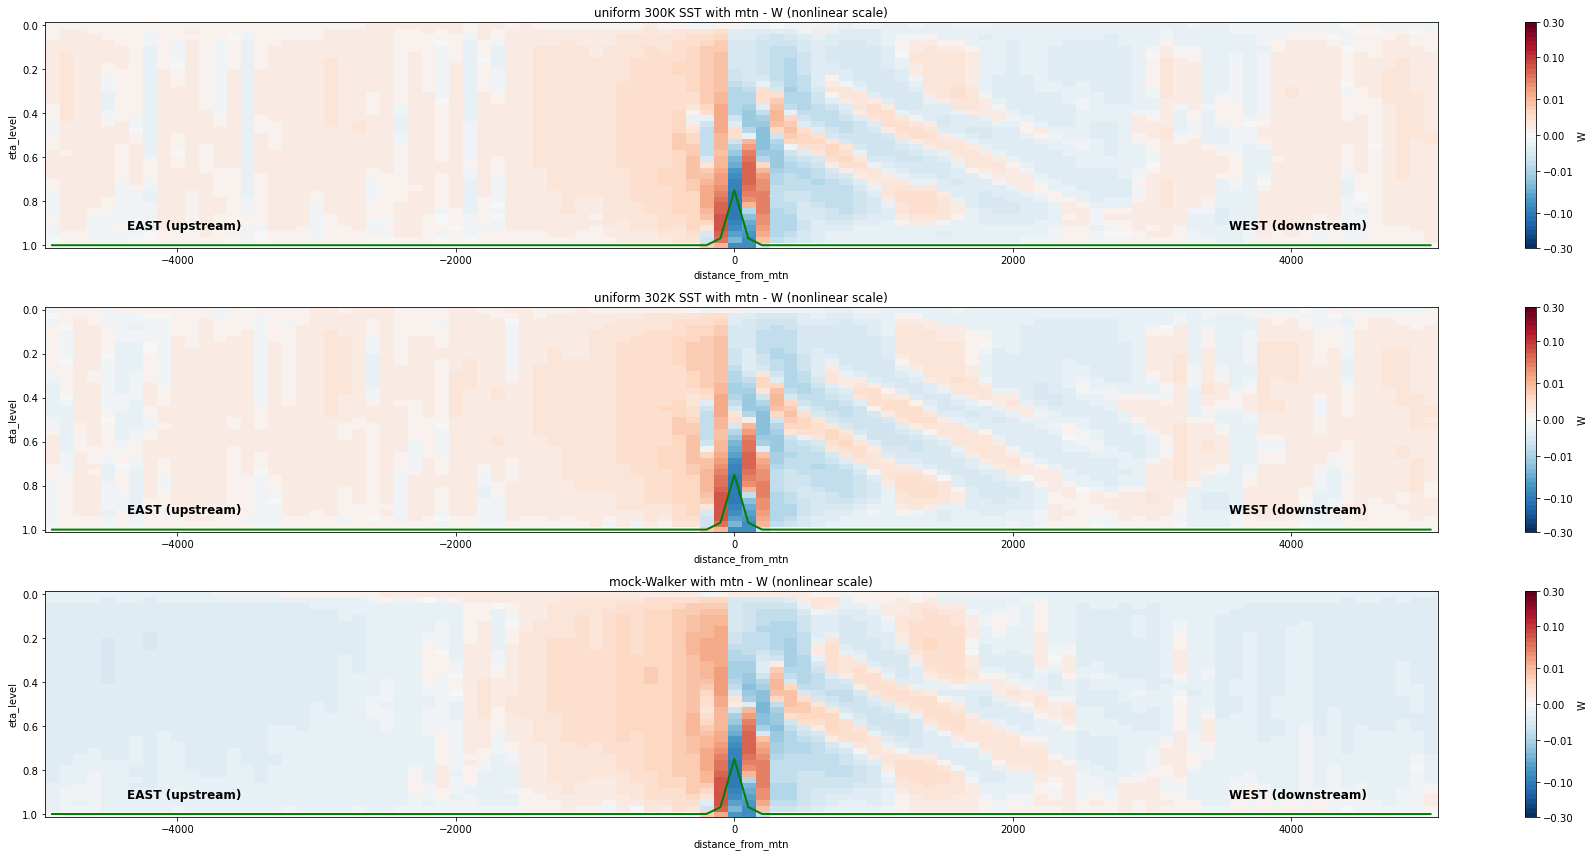

In [37]:
fig,ax=plt.subplots(3,1,figsize=(25,12))
plot_w(channel10            ,ax[0],1,0)
plot_w(channel10_302        ,ax[1],1,0)
plot_w(channel10wk          ,ax[2],1,0)
ax[0].set_title("uniform 300K SST with mtn - W (nonlinear scale)")
ax[1].set_title("uniform 302K SST with mtn - W (nonlinear scale)")
ax[2].set_title("mock-Walker with mtn - W (nonlinear scale)")

fig.tight_layout()
    


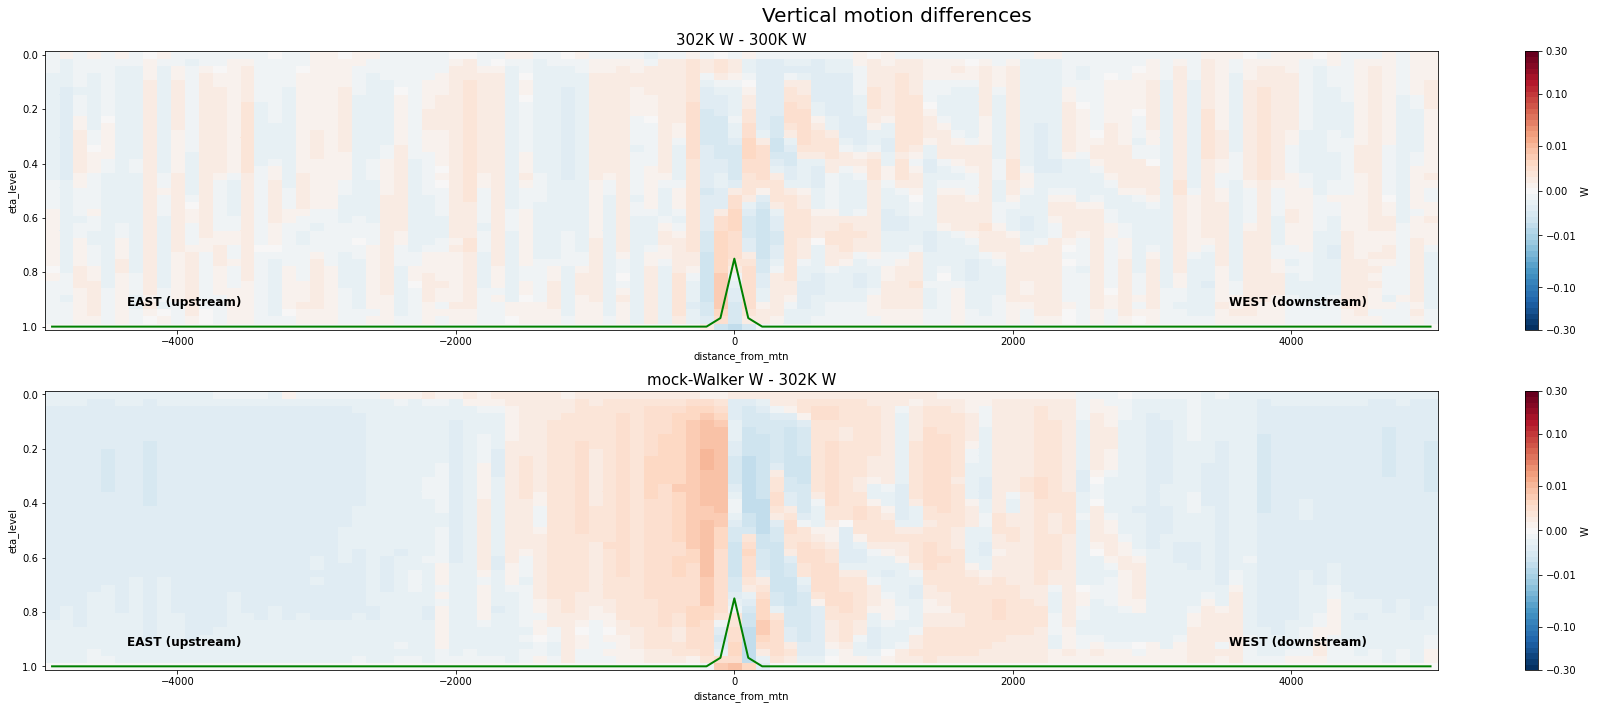

In [44]:
def plot_w_diff(sim,sim2,ax):
    w = sim2.W.isel(Time=slice(200,1000)).mean(["Time","south_north"])-sim.W.isel(Time=slice(200,1000)).mean(["Time","south_north"])
    w_plot = w.assign_coords({'distance_from_mtn':(50-w.west_east)*100,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    add_text(ax)
    ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)

fig,ax=plt.subplots(2,1,figsize=(25,10))
plot_w_diff(channel10 ,channel10_302 ,ax[0])
plot_w_diff(channel10_302,channel10wk,ax[1])
ax[0].set_title("302K W - 300K W",fontsize=15)
ax[1].set_title("mock-Walker W - 302K W",fontsize=15)

fig.suptitle("Vertical motion differences",fontsize=20)
fig.tight_layout()
    

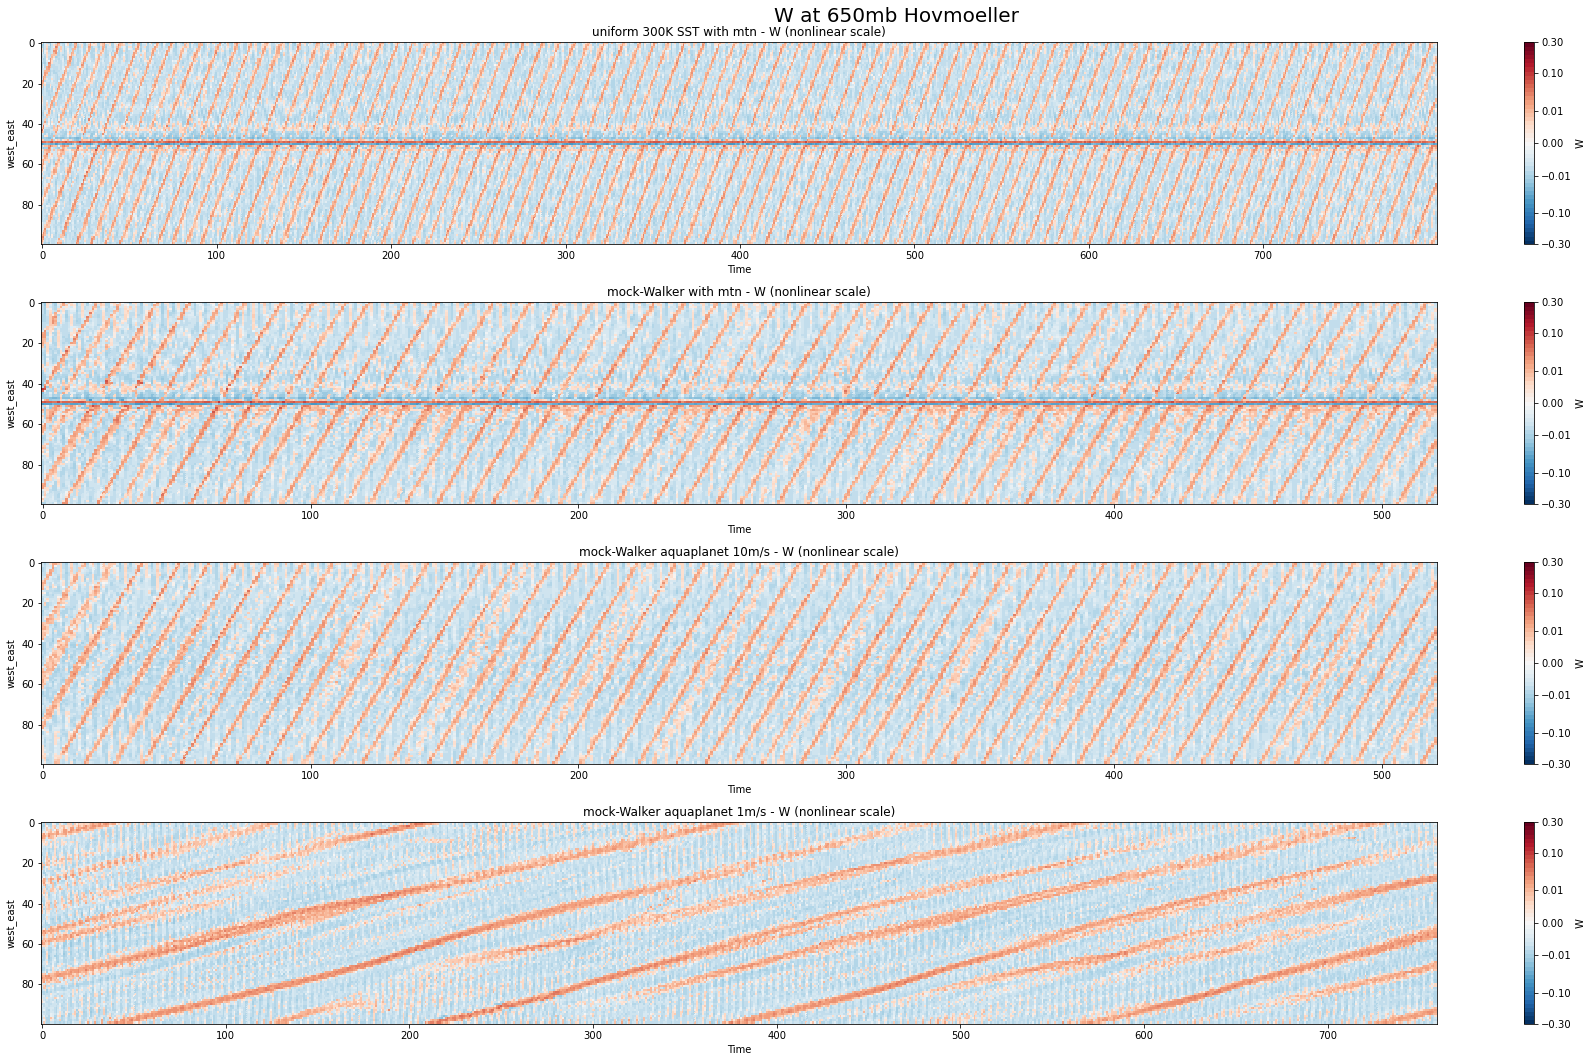

In [16]:
fig,ax=plt.subplots(4,1,figsize=(25,15))
plot_w_hovmoeller(channel10            ,ax[0])
plot_w_hovmoeller(channel10wk          ,ax[1])
plot_w_hovmoeller(channel10wk_aqua     ,ax[2])
plot_w_hovmoeller(channel10wk_aqua_1mps,ax[3])
ax[0].set_title("uniform 300K SST with mtn - W (nonlinear scale)")
ax[1].set_title("mock-Walker with mtn - W (nonlinear scale)")
ax[2].set_title("mock-Walker aquaplanet 10m/s - W (nonlinear scale)")
ax[3].set_title("mock-Walker aquaplanet 1m/s - W (nonlinear scale)")

fig.suptitle("W at 650mb Hovmoeller",fontsize=20)
fig.tight_layout()


Text(0.5, 1.0, 'mock-Walker aquaplanet 1m/s - precip (mm/day)')

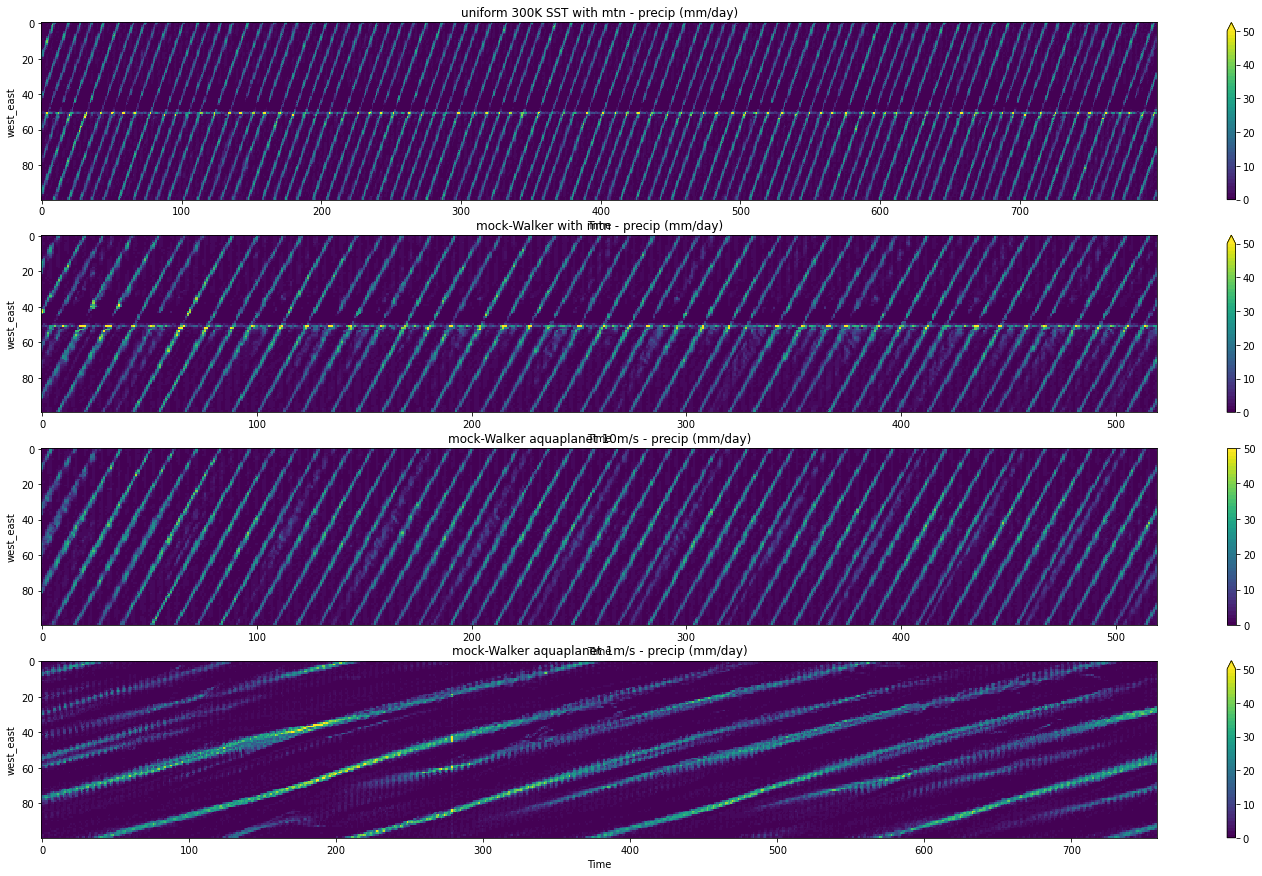

In [17]:
_,ax=plt.subplots(4,1,figsize=(25,15))
plot_pr_hovmoeller(channel10            ,ax[0])
plot_pr_hovmoeller(channel10wk          ,ax[1])
plot_pr_hovmoeller(channel10wk_aqua     ,ax[2])
plot_pr_hovmoeller(channel10wk_aqua_1mps,ax[3])
ax[0].set_title("uniform 300K SST with mtn - precip (mm/day)")
ax[1].set_title("mock-Walker with mtn - precip (mm/day)")
ax[2].set_title("mock-Walker aquaplanet 10m/s - precip (mm/day)")
ax[3].set_title("mock-Walker aquaplanet 1m/s - precip (mm/day)")

    


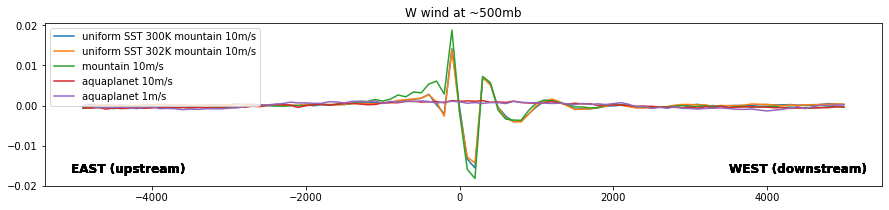

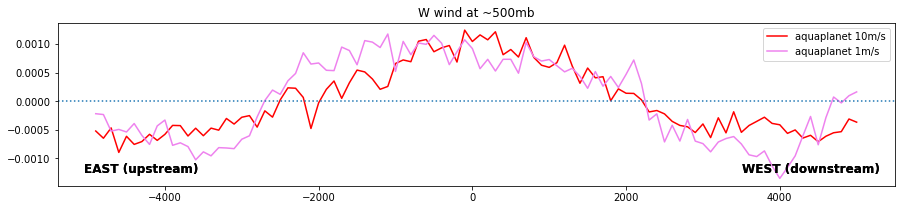

In [19]:
def plotw1d(sim,desc,ax=None,color=None):
    if not ax:
        fig,ax=plt.subplots(1,1,figsize=(15,3))
    w850 = sim.W.isel(Time=slice(200,1000),bottom_top_stag=21).mean(["Time","south_north"])
    w850=w850.assign_coords({'distance_from_mtn':(50-w850.west_east)*100})
    ax.plot(w850.distance_from_mtn,w850,label=desc,color=color)
    ax.set_title("W wind at ~500mb")
    add_text(ax)
    ax.legend()

fig,ax=plt.subplots(1,1,figsize=(15,3))
plotw1d(channel10            ,"uniform SST 300K mountain 10m/s",ax)
plotw1d(channel10_302        ,"uniform SST 302K mountain 10m/s",ax)
plotw1d(channel10wk          ,"mountain 10m/s"            ,ax)
plotw1d(channel10wk_aqua     ,"aquaplanet 10m/s"          ,ax)
plotw1d(channel10wk_aqua_1mps,"aquaplanet 1m/s"           ,ax)

fig,ax=plt.subplots(1,1,figsize=(15,3))
plotw1d(channel10wk_aqua     ,"aquaplanet 10m/s"          ,ax,'r')
plotw1d(channel10wk_aqua_1mps,"aquaplanet 1m/s"           ,ax,'violet')
ax.axhline(0.,linestyle=':')

convection shift : if the convective time scale is a few hours (say $10^4$s) and the wind speed is 10 m/s, we can expect the convective region to be shifted $10^5$m = 100 km, which is about the order of magnitude for the shift.

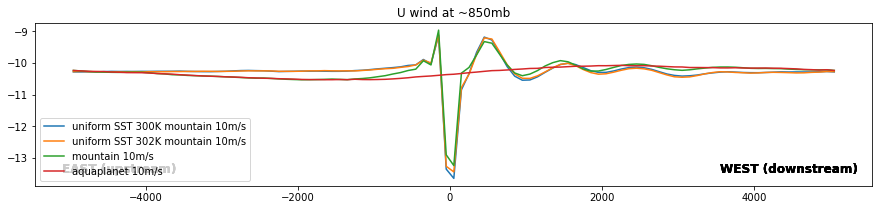

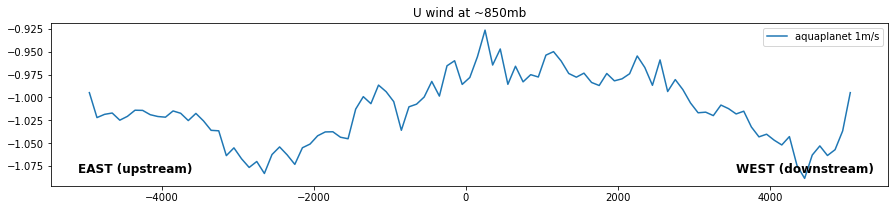

In [20]:
def plotu1d(sim,desc,ax=None):
    if not ax:
        fig,ax=plt.subplots(1,1,figsize=(15,3))
    u850 = sim.U.isel(Time=slice(200,1000),bottom_top=6).mean(["Time","south_north"])
    u850=u850.assign_coords({'distance_from_mtn':(50.5-u850.west_east_stag)*100})
    ax.plot(u850.distance_from_mtn,u850,label=desc)
    ax.set_title("U wind at ~850mb")
    add_text(ax)
    ax.legend()

fig,ax=plt.subplots(1,1,figsize=(15,3))
plotu1d(channel10            ,"uniform SST 300K mountain 10m/s",ax)
plotu1d(channel10_302        ,"uniform SST 302K mountain 10m/s",ax)
plotu1d(channel10wk,"mountain 10m/s",ax)
plotu1d(channel10wk_aqua,"aquaplanet 10m/s",ax)
plotu1d(channel10wk_aqua_1mps,"aquaplanet 1m/s")

## Precip,Cape

In [24]:
def plot_precip(sim,ax,desc,clr):
    precip = 4*(sim.RAINC+sim.RAINNC).isel(Time=slice(200,1000)).diff('Time')
    ax.set_ylabel("pr (mm/day)")
    ax.plot(dist,precip.mean(['south_north','Time']),label=desc,color=clr)


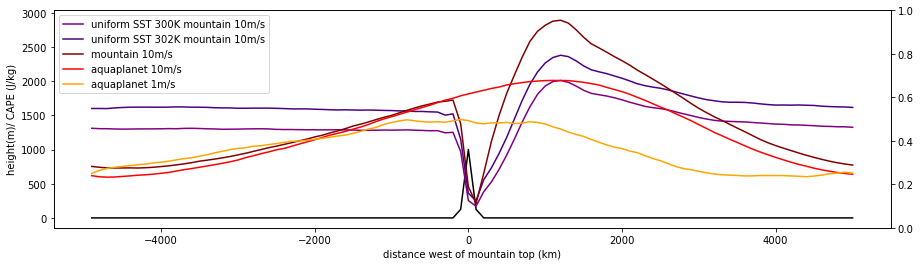

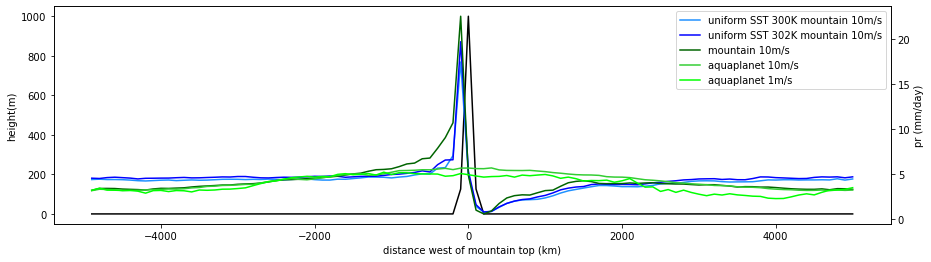

In [31]:
ax,ax2=plotsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(dist,channel10CAPEmean.mean('south_north'),          color='purple',label='uniform SST 300K mountain 10m/s'  )
ax.plot(dist,channel10_302CAPEmean.mean('south_north'),      color='indigo',label='uniform SST 302K mountain 10m/s'  )
ax.plot(dist,channel10wkCAPEmean.mean('south_north'),          color='maroon',label='mountain 10m/s'  )
ax.plot(dist,channel10wk_aquaCAPEmean.mean('south_north'),     color='r'     ,label='aquaplanet 10m/s')
ax.plot(dist,channel10wk_aqua_1mpsCAPEmean.mean('south_north'),color='orange',label='aquaplanet 1m/s' )
ax.legend()

ax,ax2=plotsection()
plot_precip(channel10            ,ax2,'uniform SST 300K mountain 10m/s'  ,'dodgerblue')
plot_precip(channel10_302        ,ax2,'uniform SST 302K mountain 10m/s'  ,'b')
plot_precip(channel10wk          ,ax2,'mountain 10m/s'  ,'darkgreen')
plot_precip(channel10wk_aqua     ,ax2,'aquaplanet 10m/s','limegreen'     )
plot_precip(channel10wk_aqua_1mps,ax2,'aquaplanet 1m/s' ,'lime')
ax2.legend()


In [14]:
def precip_max(sim):
    precip = 4*(sim.RAINC+sim.RAINNC).isel(Time=slice(200,1000)).diff('Time')
    return np.array(precip.mean(['south_north','Time']).max())


In [17]:
(precip_max(channel10_302)/precip_max(channel10)-1)/2*100


6.444358825683594

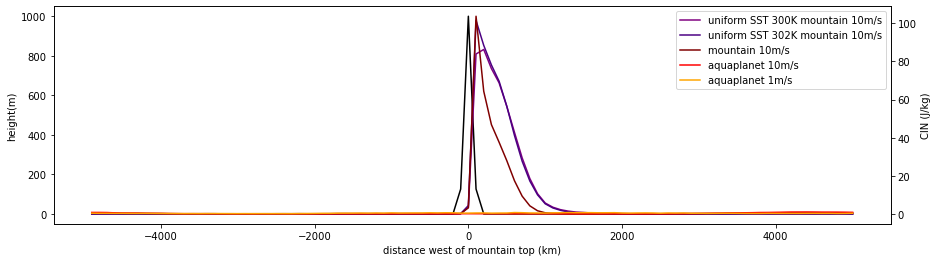

In [15]:
ax,ax2=plotsection()
ax2.set_ylabel("CIN (J/kg)")
ax2.plot(dist,channel10capecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(200,1200)).mean(['Time','south_north'])            ,color='purple',label='uniform SST 300K mountain 10m/s'  )
ax2.plot(dist,channel10_302capecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(200,1200)).mean(['Time','south_north'])        ,color='indigo',label='uniform SST 302K mountain 10m/s'  )
ax2.plot(dist,channel10wkcapecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(200,1200)).mean(['Time','south_north'])          ,color='maroon',label='mountain 10m/s'  )
ax2.plot(dist,channel10wk_aquacapecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(200,1200)).mean(['Time','south_north'])     ,color='r'     ,label='aquaplanet 10m/s')
ax2.plot(dist,channel10wk_aqua_1mpscapecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(200,1200)).mean(['Time','south_north']),color='orange',label='aquaplanet 1m/s' )
ax2.legend()

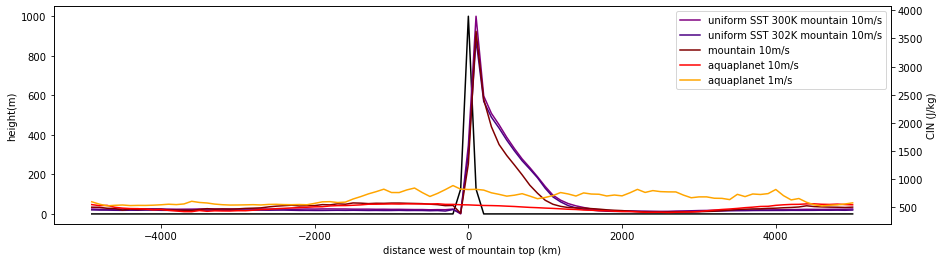

In [16]:
ax,ax2=plotsection()
ax2.set_ylabel("CIN (J/kg)")
ax2.plot(dist,channel10capecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(200,1200)).mean(['Time','south_north'])            ,color='purple',label='uniform SST 300K mountain 10m/s'  )
ax2.plot(dist,channel10_302capecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(200,1200)).mean(['Time','south_north'])        ,color='indigo',label='uniform SST 302K mountain 10m/s'  )
ax2.plot(dist,channel10wkcapecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(200,1200)).mean(['Time','south_north'])          ,color='maroon',label='mountain 10m/s'  )
ax2.plot(dist,channel10wk_aquacapecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(200,1200)).mean(['Time','south_north'])     ,color='r'     ,label='aquaplanet 10m/s')
ax2.plot(dist,channel10wk_aqua_1mpscapecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(200,1200)).mean(['Time','south_north']),color='orange',label='aquaplanet 1m/s' )
ax2.legend()

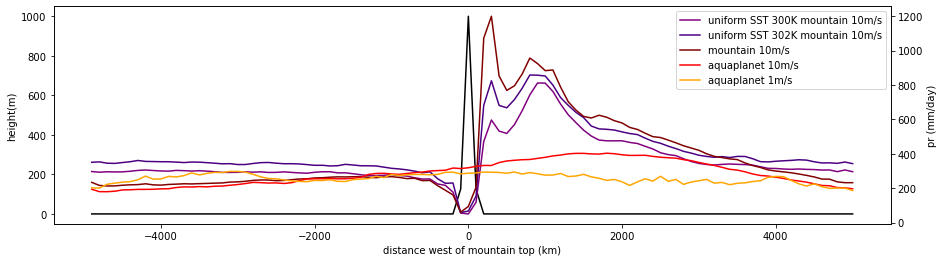

In [12]:
def plot_tauc(sim,cape,ax,desc,clr):
    precip = 4*(sim.RAINC+sim.RAINNC).isel(Time=slice(200,1000)).diff('Time')
    ax.set_ylabel("pr (mm/day)")
    ax.plot(dist,cape/precip.mean(['south_north','Time']),label=desc,color=clr)

ax,ax2=plotsection()
plot_tauc(channel10            ,channel10CAPEmean.mean('south_north')            ,ax2,'uniform SST 300K mountain 10m/s' ,'purple')
plot_tauc(channel10_302        ,channel10_302CAPEmean.mean('south_north')        ,ax2,'uniform SST 302K mountain 10m/s' ,'indigo')
plot_tauc(channel10wk          ,channel10wkCAPEmean.mean('south_north')          ,ax2,'mountain 10m/s'                  ,'maroon')
plot_tauc(channel10wk_aqua     ,channel10wk_aquaCAPEmean.mean('south_north')     ,ax2,'aquaplanet 10m/s'                ,'r'     )
plot_tauc(channel10wk_aqua_1mps,channel10wk_aqua_1mpsCAPEmean.mean('south_north'),ax2,'aquaplanet 1m/s'                 ,'orange')
ax2.legend()

Text(0.5, 1.0, 'zoom close to mountain')

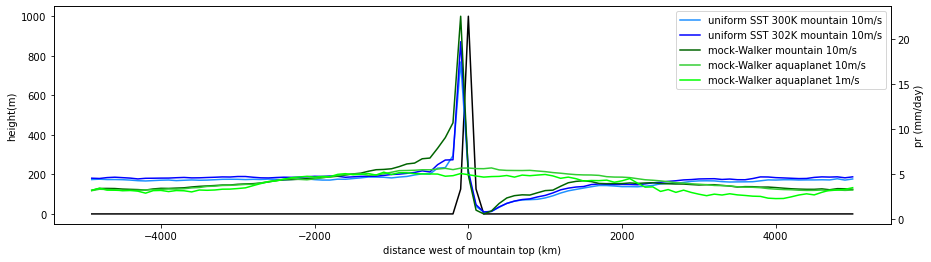

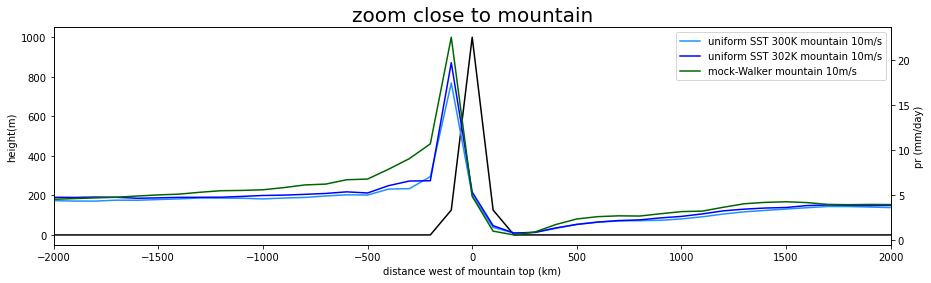

In [34]:
ax,ax2=plotsection()
plot_precip(channel10            ,ax2,'uniform SST 300K mountain 10m/s'  ,'dodgerblue')
plot_precip(channel10_302        ,ax2,'uniform SST 302K mountain 10m/s'  ,'b')
plot_precip(channel10wk          ,ax2,'mock-Walker mountain 10m/s'  ,'darkgreen')
plot_precip(channel10wk_aqua     ,ax2,'mock-Walker aquaplanet 10m/s','limegreen'     )
plot_precip(channel10wk_aqua_1mps,ax2,'mock-Walker aquaplanet 1m/s' ,'lime')
ax2.legend()

ax,ax2=plotsection()
plot_precip(channel10            ,ax2,'uniform SST 300K mountain 10m/s'  ,'dodgerblue')
plot_precip(channel10_302        ,ax2,'uniform SST 302K mountain 10m/s'  ,'b')
plot_precip(channel10wk          ,ax2,'mock-Walker mountain 10m/s'  ,'darkgreen')
ax2.legend()
ax.set_xlim(-2000,2000)
ax.set_title ("zoom close to mountain",fontsize=20)


In [ ]:
print(1)

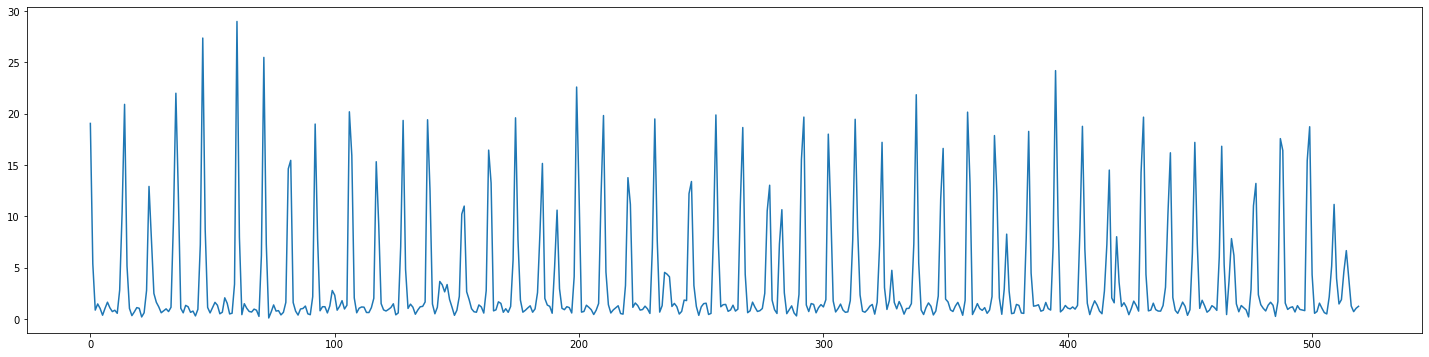

In [137]:
channel10precip = 4*(channel10wk_aqua.RAINC+channel10wk_aqua.RAINNC).isel(Time=slice(200,1000)).diff('Time')
channel10precip_timeseries = channel10precip.sel(west_east=slice(80,82)).mean(['south_north','west_east'])
plt.figure(figsize=(25,6))
plt.plot(channel10precip_timeseries.Time,channel10precip_timeseries)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


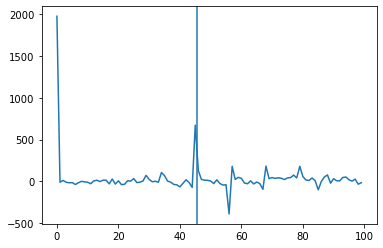

In [138]:
# Fourier transform precip over mtn to see main modes.
plt.plot((np.fft.fft(channel10precip_timeseries)[:100]))
plt.axvline(500/11)

## RH profiles

In [47]:
path_channel10             = "/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/"
path_channel10wk           = "/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.walker.100km/"
path_channel10wk_aqua      = "/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.10mps.walker.100km/"
path_channel10wk_aqua_1mps = "/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.aquaplanet.1mps.walker.100km/"

In [72]:
def get_rh(path):
    try :
        file="wrfout_d01_1970-04-21_00:00:00"
        rh=wrf.getvar(Dataset(path+file),'rh',wrf.ALL_TIMES)
    except FileNotFoundError:
        file="wrfout_d01_1970-04-21_00_00_00"
        rh=wrf.getvar(Dataset(path+file),'rh',wrf.ALL_TIMES)
    return rh

def plot_rh(rh,ax,plot_mtn=0,scale=0):
    rh=rh.mean(["Time","south_north"])
    rh_plot = rh.assign_coords({'distance_from_mtn':(50-rh.west_east)*100,'eta_level':channel10.ZNU.isel(Time=-1)}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'})
    if scale :
        cf=rh_plot.plot.contourf(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.arange(-20,21,5.))
    else :
        cf=rh_plot.plot.contourf(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.arange(0,101,10.))
    ax.clabel(cf, inline=False, fontsize=8, fmt="%i",colors='k')
    add_text(ax)
    if plot_mtn :
        ax.plot(rh_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)

In [67]:
rh_channel10             = get_rh(path_channel10            )
rh_channel10wk           = get_rh(path_channel10wk          )
rh_channel10wk_aqua      = get_rh(path_channel10wk_aqua     )
rh_channel10wk_aqua_1mps = get_rh(path_channel10wk_aqua_1mps)

In [77]:
0.01*10**4 / 0.5e-4

2000000.0

Text(0.5, 1.0, 'mock-Walker aquaplanet 10m/s - RH')

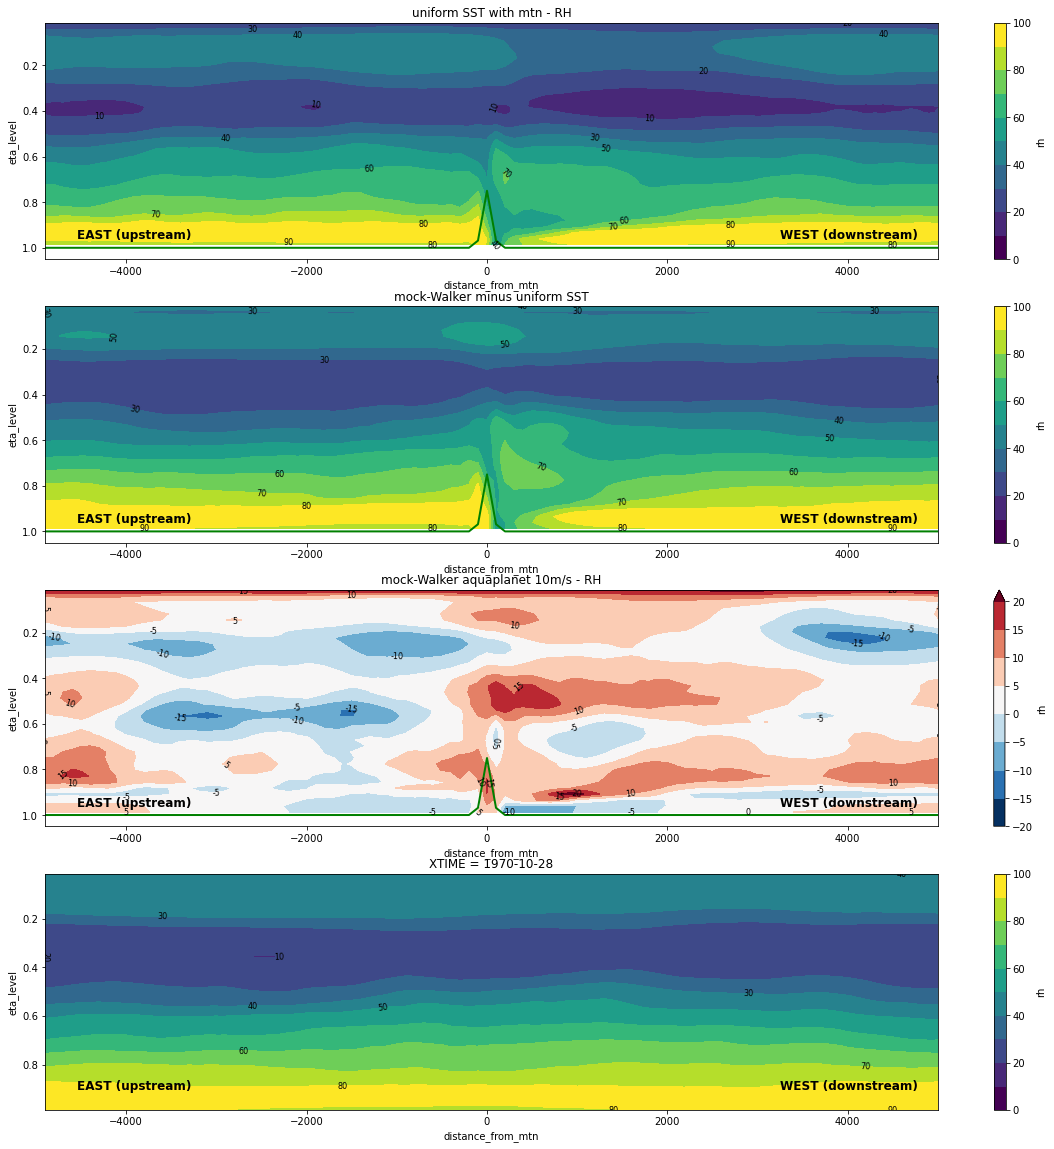

In [73]:
_,ax=plt.subplots(4,1,figsize=(20,20))
plot_rh(rh_channel10            ,ax[0],1)
plot_rh(rh_channel10wk          ,ax[1],1)
plot_rh(rh_channel10wk-rh_channel10,ax[2],1,1)
plot_rh(rh_channel10wk_aqua     ,ax[3])
ax[0].set_title("uniform 300K SST with mtn - RH")
ax[1].set_title("mock-Walker with mtn - RH")
ax[1].set_title("mock-Walker minus uniform SST")
ax[2].set_title("mock-Walker aquaplanet 10m/s - RH")

    
